In [143]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from PIL import Image
import os
import matplotlib.pyplot as plt

In [144]:
#create training data

In [145]:
folder = "./bmw10_release/bmw10_ims/"

Npixels = 25
Nchannels = 3

cars = []

for d in os.listdir(folder):
    for f in os.listdir(folder+d):
        img = Image.open(folder+d+'/'+f)
        
        img = img.resize((Npixels, Npixels))
        
        cars.append(np.asarray(img))
        
cars = np.asarray(cars)
print cars.shape

NUM_CARS = cars.shape[0]

(512, 25, 25, 3)


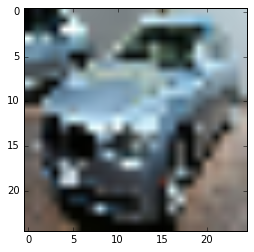

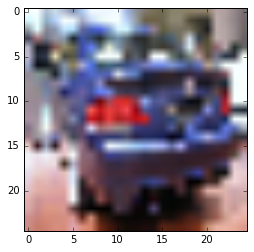

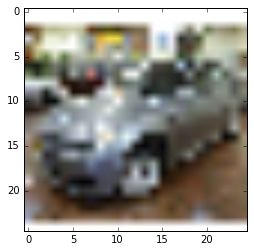

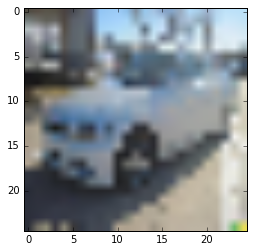

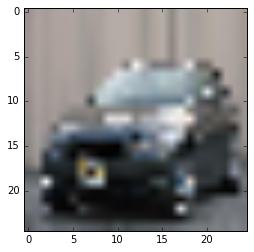

In [146]:
#plot some random images
Num_images_to_plot = 5
for i in range(0,Num_images_to_plot):
    index = np.random.randint(NUM_CARS)
    
    plt.imshow(cars[index,:])
    plt.show()

In [147]:
#normalize data

In [148]:
means = np.mean(cars, axis=(0,1,2))
stdevs = np.std(cars,axis=(0,1,2))

print means
print stdevs

cars_norm = (cars-means)/stdevs

print np.mean(cars_norm, axis=(0,1,2))
print np.std(cars_norm,axis=(0,1,2))

[ 116.94784687  117.20950312  115.99665312]
[ 72.07456184  71.47683711  73.89948193]
[  8.69663890e-16  -1.23780049e-15   1.62429514e-15]
[ 1.  1.  1.]


In [149]:
#define network structure
NBATCH = 100
W_init = 0.01

G_Nunits1 = 100


In [150]:
x = tf.placeholder(tf.float32, shape=(NBATCH,Npixels,Npixels,Nchannels))
z = tf.placeholder(tf.float32, shape=(NBATCH,1))

In [151]:
#generator network

In [152]:
G_w1 = tf.Variable(
    tf.random_normal(shape=(1,G_Nunits1),stddev=W_init)
)

G_b1 = tf.Variable(
    tf.zeros(shape=(1,G_Nunits1))
)

G_hidden1 = tf.nn.relu(tf.matmul(z,G_w1)+G_b1)

G_w2 = tf.Variable(
    tf.random_normal(shape=(G_Nunits1, Npixels*Npixels*Nchannels),stddev=W_init)
)

G_b2 = tf.Variable(
    tf.zeros(shape=(1, Npixels*Npixels*Nchannels))
)

G_out = tf.reshape(
    tf.matmul(G_hidden1, G_w2)+G_b2,
    shape=(NBATCH,Npixels,Npixels,Nchannels)
)

In [153]:
#Discriminator network
Nfilters = 6
Conv_Shape = 3
strides = [1,1,1,1]

In [154]:
D_w1 = tf.Variable(
    tf.random_normal(shape=(Conv_Shape,Conv_Shape,Nchannels,Nfilters),
                    stddev=W_init
                    )
)

D_b1 = tf.Variable(
    tf.zeros(shape=[Nfilters])
)

D_w2 = tf.Variable(
    tf.random_normal(shape=(Conv_Shape,Conv_Shape,Nfilters,Nfilters),
                    stddev=W_init
                    )
)

D_b2 = tf.Variable(
    tf.zeros(shape=[Nfilters])
)

D_w3 = tf.Variable(
    tf.random_normal(shape=(Nfilters*Npixels**2,1),
                    stddev=W_init
                    )
)

D_b3 = tf.Variable(
    tf.zeros(shape=(1,Nfilters*Npixels**2))
)

In [155]:
#pass real data through discriminator
def Pass_through_discriminator(x_in):
    D_real_out1 = tf.nn.conv2d(x_in, D_w1, strides, padding="SAME")
    D_real_out1 = tf.nn.bias_add(D_real_out1, D_b1)
    D_real_out1 = tf.nn.relu(D_real_out1)

    D_real_out2 = tf.nn.conv2d(D_real_out1, D_w2, strides, padding="SAME")
    D_real_out2 = tf.nn.bias_add(D_real_out2, D_b2)
    D_real_out2 = tf.nn.relu(D_real_out2)

    D_real_out3 = tf.reshape(D_real_out2,[NBATCH,-1])
    D_real_out3 = tf.matmul(D_real_out3,D_w3)+D_b3
    D_real_out3 = tf.nn.sigmoid(D_real_out3)
    
    return D_real_out3

In [156]:
real_out = Pass_through_discriminator(x)

fake_out = Pass_through_discriminator(G_out)

In [157]:
#loss functions

In [158]:
D_loss = -tf.reduce_mean(tf.log(real_out)) -\
tf.reduce_mean(tf.log(1-fake_out))

G_loss1 = -tf.reduce_mean(tf.log(fake_out))

G_loss2 = tf.reduce_mean(tf.log(1-fake_out))

In [159]:
#set up optimization
lr = 1e-3
momentum = 0.9

In [160]:
opt = tf.train.MomentumOptimizer(lr,momentum)

D_train = opt.minimize(D_loss, var_list=[D_w1,D_b1,D_w2,D_b2,D_w3,D_b3])

G_train1 = opt.minimize(G_loss1, var_list=[G_w1,G_b1,G_w2,G_b2])

G_train2 = opt.minimize(G_loss2, var_list=[G_w1,G_b1,G_w2,G_b2])

In [161]:
#set up session and initialize
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [162]:
#set up training loop
Niter1 = 10
Niter2 = 10
kd = 10
kg = 1000
print_step = 100

def get_batch(xdata, nbatch):
    N = xdata.shape[0]
    inds = np.random.choice(N, size=nbatch, replace=False)
    xret = xdata[inds,:]

    return xret

In [163]:
#training loop 1
for step in xrange(Niter1+1):

    
    print "Discriminator\n"
    for i in range(0,kd):    
        x_batch = get_batch(cars_norm, NBATCH)
        z_batch = np.random.rand(NBATCH,1)
        
        sess.run(D_train,feed_dict={x:x_batch,z:z_batch})
    
        dl=sess.run(D_loss,feed_dict={x:x_batch,z:z_batch})
        gl=sess.run(G_loss1,feed_dict={z:z_batch})
        
        print "Discriminator loss: ", dl, ", Generator loss: ", gl
    
    print "Generator\n"
    for i in range(0,kg):
        z_batch = np.random.rand(NBATCH,1)
        
        sess.run(G_train1, feed_dict={z:z_batch})
        
        if i % print_step == 0:
            dl=sess.run(D_loss,feed_dict={x:x_batch,z:z_batch})
            gl=sess.run(G_loss1,feed_dict={z:z_batch})

            print "Discriminator loss: ", dl, ", Generator loss: ", gl

Discriminator

Discriminator loss:  1.3864 , Generator loss:  0.693161
Discriminator loss:  1.3864 , Generator loss:  0.693189
Discriminator loss:  1.38633 , Generator loss:  0.693227
Discriminator loss:  1.38621 , Generator loss:  0.69328
Discriminator loss:  1.38619 , Generator loss:  0.693313
Discriminator loss:  1.38616 , Generator loss:  0.693364
Discriminator loss:  1.38608 , Generator loss:  0.693428
Discriminator loss:  1.38601 , Generator loss:  0.693499
Discriminator loss:  1.38603 , Generator loss:  0.69357
Discriminator loss:  1.38587 , Generator loss:  0.693646
Generator

Discriminator loss:  1.38587 , Generator loss:  0.693646
Discriminator loss:  1.38587 , Generator loss:  0.693646
Discriminator loss:  1.38587 , Generator loss:  0.693646
Discriminator loss:  1.38587 , Generator loss:  0.693646
Discriminator loss:  1.38587 , Generator loss:  0.693646
Discriminator loss:  1.38587 , Generator loss:  0.693646
Discriminator loss:  1.38587 , Generator loss:  0.693646
Discrimin

In [164]:
#training loop 2
for step in xrange(Niter2+1):
    
    print "Discriminator\n"
    for i in range(0,kd):
        x_batch = get_batch(cars_norm, NBATCH)
        z_batch = np.random.rand(NBATCH,1)
    
        sess.run(D_train,feed_dict={x:x_batch,z:z_batch})
    
        dl=sess.run(D_loss,feed_dict={x:x_batch,z:z_batch})
        gl=sess.run(G_loss2,feed_dict={z:z_batch})
        
        print "Discriminator loss: ", dl, ", Generator loss: ", gl
    
    print "Generator\n"
    for i in range(0,kg):
        z_batch = np.random.rand(NBATCH,1)
        sess.run(G_train2, feed_dict={z:z_batch})
        
        if i % print_step == 0:
            dl=sess.run(D_loss,feed_dict={x:x_batch,z:z_batch})
            gl=sess.run(G_loss2,feed_dict={z:z_batch})

            print "Discriminator loss: ", dl, ", Generator loss: ", gl

Discriminator

Discriminator loss:  1.0916 , Generator loss:  -0.627732
Discriminator loss:  1.0637 , Generator loss:  -0.622015
Discriminator loss:  1.00903 , Generator loss:  -0.615879
Discriminator loss:  0.98709 , Generator loss:  -0.609684
Discriminator loss:  0.939935 , Generator loss:  -0.602222
Discriminator loss:  0.903777 , Generator loss:  -0.593697
Discriminator loss:  0.842505 , Generator loss:  -0.584072
Discriminator loss:  0.793813 , Generator loss:  -0.573164
Discriminator loss:  0.752542 , Generator loss:  -0.561596
Discriminator loss:  0.714517 , Generator loss:  -0.548692
Generator

Discriminator loss:  0.71452 , Generator loss:  -0.548695
Discriminator loss:  0.715629 , Generator loss:  -0.549804
Discriminator loss:  0.717034 , Generator loss:  -0.551209
Discriminator loss:  0.71867 , Generator loss:  -0.552845
Discriminator loss:  0.720489 , Generator loss:  -0.554664
Discriminator loss:  0.722461 , Generator loss:  -0.556637
Discriminator loss:  0.724599 , Genera

KeyboardInterrupt: 

In [26]:
#generate some cars

(100, 25, 25, 3)


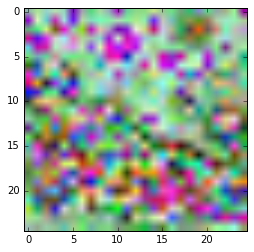

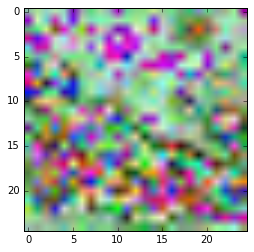

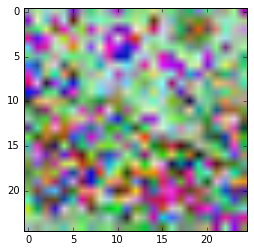

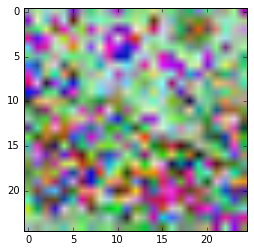

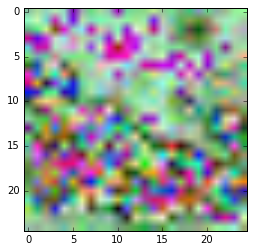

In [165]:
z_batch = np.random.rand(NBATCH,1)

gen_cars = sess.run(G_out, feed_dict={z:z_batch})
print gen_cars.shape
#plot some random images
Num_images_to_plot = 5
for i in range(0,Num_images_to_plot):
    index = np.random.randint(NBATCH)
    
    plt.imshow((gen_cars[index,:]*stdevs)+means)
    plt.show()